In [41]:
print("Columnas en resultados:", resultados.columns.tolist())

Columnas en resultados: ['es_anomalia', 'score_anomalia', 'THD']


In [1]:
# 1. 🔧 CONFIGURACIÓN CON LAS RUTAS 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import joblib
from datetime import datetime, timedelta
import uuid
import json

warnings.filterwarnings('ignore')

# 🎯 RUTAS EXACTAS
BASE_PATH = Path(r'C:\TFM-pipeline')
MODELO_PATH = BASE_PATH / 'modelo_predictivo_tfm.pkl'
INPUT_PATH = BASE_PATH / 'INPUT'
OUTPUT_PATH = BASE_PATH / 'output'

OUTPUT_PATH.mkdir(exist_ok=True)

print("🔍 SISTEMA DE INFERENCIA REAL")
print(f"📁 Modelo: {MODELO_PATH}")
print(f"📁 Datos: {INPUT_PATH}")
print("=" * 50)

🔍 SISTEMA DE INFERENCIA REAL
📁 Modelo: C:\TFM-pipeline\modelo_predictivo_tfm.pkl
📁 Datos: C:\TFM-pipeline\INPUT


In [3]:
# 2. 🔍 CARGAR MODELO 
print("🔍 CARGANDO MODELO ")

datos_modelo = joblib.load(MODELO_PATH)
modelo_cargado = datos_modelo['modelo_if']
scaler_cargado = datos_modelo['scaler']
variables_modelo = datos_modelo['variables']

print(f"✅ Modelo: {type(modelo_cargado).__name__}")
print(f"✅ Scaler: {type(scaler_cargado).__name__}")
print(f"✅ Variables: {len(variables_modelo)} variables")
print(f"✅ Compresor: {datos_modelo['compresor']}")

print(f"\n📋 Variables del modelo:")
for i, var in enumerate(variables_modelo, 1):
    print(f"   {i:2d}. {var}")

🔍 CARGANDO MODELO 
✅ Modelo: IsolationForest
✅ Scaler: StandardScaler
✅ Variables: 11 variables
✅ Compresor: C1

📋 Variables del modelo:
    1. THD_Corriente_A
    2. THD_Corriente_B
    3. THD_Corriente_C
    4. THD_Voltaje_A
    5. THD_Voltaje_B
    6. THD_Voltaje_Promedio
    7. THD_Voltaje_C
    8. THD
    9. Potencia_A
   10. Potencia_B
   11. Potencia_C


In [5]:
# 3. 📊 CARGAR Y PROCESAR DATOS DE AGOSTO
print("📊 CARGANDO DATOS DE AGOSTO 2025...")
print("=" * 40)

archivo_datos = INPUT_PATH / 'Informacion Agosto_fp1.xlsx'
datos_agosto = pd.read_excel(archivo_datos)

# Procesar fechas
datos_agosto['Hora'] = pd.to_datetime(datos_agosto['Hora'])
datos_agosto.set_index('Hora', inplace=True)

# Filtrar solo operación (potencia > 0)
potencia_cols = [col for col in datos_agosto.columns if 'Demanda' in col]
datos_agosto['Potencia_Total'] = datos_agosto[potencia_cols].sum(axis=1)
datos_operacion = datos_agosto[datos_agosto['Potencia_Total'] > 0].copy()

print(f"✅ Datos cargados exitosamente")
print(f"   📊 Total registros: {len(datos_agosto):,}")
print(f"   📊 Registros operación: {len(datos_operacion):,}")
print(f"   📅 Período: {datos_operacion.index.min()} a {datos_operacion.index.max()}")

📊 CARGANDO DATOS DE AGOSTO 2025...
✅ Datos cargados exitosamente
   📊 Total registros: 8,064
   📊 Registros operación: 4,410
   📅 Período: 2025-08-01 00:05:00+04:00 a 2025-08-28 17:20:00+04:00


In [7]:
# 4. 🔧 PREPARAR VARIABLES PARA EL MODELO
print("🔧 PREPARANDO VARIABLES PARA EL MODELO...")
print("=" * 45)

# Mapeo de columnas
mapeo_columnas = {
    'THD_Corriente_A': 'Compresor C-1 - Calidad de la Energía: Distorsión Armónica Total Actual - Fase A',
    'THD_Corriente_B': 'Compresor C-1 - Calidad de la Energía: Distorsión Armónica Total Actual - Fase B',
    'THD_Corriente_C': 'Compresor C-1 - Calidad de la Energía: Distorsión Armónica Total Actual - Fase C',
    'THD_Voltaje_A': 'Compresor C-1 - Calidad de la Energía: Distorsión Armónica Total de Voltaje - Fase A',
    'THD_Voltaje_B': 'Compresor C-1 - Calidad de la Energía: Distorsión Armónica Total de Voltaje - Fase B',
    'THD_Voltaje_C': 'Compresor C-1 - Calidad de la Energía: Distorsión Armónica Total de Voltaje - Fase C',
    'THD_Voltaje_Promedio': 'Compresor C-1 - Calidad de la Energía: Distorsión Armónica Total de Voltaje - Promedio',
    'Potencia_A': 'Compresor C-1 - Calidad de la Energía: Demanda - Fase A (kW)',
    'Potencia_B': 'Compresor C-1 - Calidad de la Energía: Demanda - Fase B (kW)',
    'Potencia_C': 'Compresor C-1 - Calidad de la Energía: Demanda - Fase C (kW)'
}

# Crear DataFrame para el modelo
X_agosto = pd.DataFrame()
for var_modelo, col_datos in mapeo_columnas.items():
    if col_datos in datos_operacion.columns:
        X_agosto[var_modelo] = datos_operacion[col_datos]

# Calcular THD promedio
thd_cols = [col for col in X_agosto.columns if 'THD' in col]
X_agosto['THD'] = X_agosto[thd_cols].mean(axis=1)

# Limpiar datos
X_agosto = X_agosto.dropna()

print(f"✅ Variables preparadas: {len(X_agosto.columns)}")
print(f"✅ Registros válidos: {len(X_agosto):,}")
print(f"✅ Variables del modelo disponibles: {len([v for v in variables_modelo if v in X_agosto.columns])}")

🔧 PREPARANDO VARIABLES PARA EL MODELO...
✅ Variables preparadas: 11
✅ Registros válidos: 4,410
✅ Variables del modelo disponibles: 11


In [9]:
# 5. 🔍 APLICAR MODELO Y DETECTAR ANOMALÍAS
print("🔍 APLICANDO MODELO Y DETECTANDO ANOMALÍAS...")
print("=" * 50)

# Aplicar modelo
X_scaled = scaler_cargado.transform(X_agosto[variables_modelo])
predicciones = modelo_cargado.predict(X_scaled)
scores = modelo_cargado.score_samples(X_scaled)

# Crear resultados
resultados = pd.DataFrame({
    'es_anomalia': predicciones == -1,
    'score_anomalia': scores,
    'THD': X_agosto['THD'].values
})
resultados.index = X_agosto.index  # USAR FECHAS REALES

# Crear anomalías para OTs (CORREGIDO)
anomalias_para_ots = resultados[resultados['es_anomalia']].copy()
anomalias_para_ots['compresor'] = 'C1'
anomalias_para_ots['tipo_anomalia'] = 'THD_ELEVADO'
anomalias_para_ots['fecha_deteccion'] = anomalias_para_ots.index  # FECHAS REALES

print(f"📊 Total registros procesados: {len(resultados):,}")
print(f"🚨 Anomalías detectadas: {len(anomalias_para_ots):,}")
print(f"📈 Porcentaje de anomalías: {len(anomalias_para_ots)/len(resultados)*100:.2f}%")

🔍 APLICANDO MODELO Y DETECTANDO ANOMALÍAS...
📊 Total registros procesados: 4,410
🚨 Anomalías detectadas: 212
📈 Porcentaje de anomalías: 4.81%


In [11]:
# 6. 📊 CLASIFICAR ANOMALÍAS POR SEVERIDAD
print("📊 CLASIFICANDO ANOMALÍAS POR SEVERIDAD...")
print("=" * 45)

def calcular_severidad(row):
    """Calcula la severidad basada en THD y score de anomalía"""
    if not row['es_anomalia']:
        return 'NORMAL'
    
    thd = row.get('THD', 0)
    score = row['score_anomalia']
    
    if thd > 3.5:  # Solo THD extremadamente alto
        return 'CRÍTICO'
    elif thd > 2.0 or score < -0.4:
        return 'ALERTA'
    elif thd > 1.5 or score < -0.2:
        return 'ATENCIÓN'
    else:
        return 'MENOR'

# Aplicar clasificación
anomalias_para_ots['severidad'] = anomalias_para_ots.apply(calcular_severidad, axis=1)

# Mostrar distribución
distribucion = anomalias_para_ots['severidad'].value_counts()
print(f"🚨 DISTRIBUCIÓN POR SEVERIDAD:")
for severidad, cantidad in distribucion.items():
    emoji = {'CRÍTICO': '🔴', 'ALERTA': '🟠', 'ATENCIÓN': '🟡', 'MENOR': '🔵'}.get(severidad, '⚪')
    print(f"   {emoji} {severidad}: {cantidad:,}")

📊 CLASIFICANDO ANOMALÍAS POR SEVERIDAD...
🚨 DISTRIBUCIÓN POR SEVERIDAD:
   🟠 ALERTA: 209
   🔴 CRÍTICO: 3


In [13]:
# 7. 🔧 CONFIGURACIÓN PARA GENERACIÓN DE OTs
print("🔧 CONFIGURACIÓN PARA GENERACIÓN DE OTs...")
print("=" * 45)

# Configuración de la planta
config_planta = {
    'codigo_planta': 'FP1',
    'nombre_planta': 'Planta de Refrigeración Industrial',
    'equipo_principal': 'Compresor C-1 de Tornillo GEA',
    'ubicacion': 'Sala de Compresores - Nivel 1',
    'responsable': 'Departamento de Mantenimiento'
}

# Mapeos de severidad
mapeo_tipo_ot = {
    'CRÍTICO': 'CORRECTIVO',
    'ALERTA': 'PREDICTIVO',
    'ATENCIÓN': 'PREVENTIVO',
    'MENOR': 'INSPECCIÓN'
}

mapeo_prioridad = {
    'CRÍTICO': 1,
    'ALERTA': 2,
    'ATENCIÓN': 3,
    'MENOR': 4
}

mapeo_tiempo_respuesta = {
    'CRÍTICO': {'horas': 2, 'descripcion': '2 horas'},
    'ALERTA': {'horas': 8, 'descripcion': '8 horas'},
    'ATENCIÓN': {'horas': 24, 'descripcion': '24 horas'},
    'MENOR': {'horas': 168, 'descripcion': '1 semana'}
}

print("✅ Configuración cargada exitosamente")

🔧 CONFIGURACIÓN PARA GENERACIÓN DE OTs...
✅ Configuración cargada exitosamente


In [33]:
# 8. 🛠️ FUNCIONES AUXILIARES PARA GENERACIÓN DE OTs
print("🛠️ DEFINIENDO FUNCIONES AUXILIARES...")

def determinar_especialidad(thd, severidad, score):
    """Determina la especialidad requerida basada en los parámetros"""
    if thd > 3.5 or severidad in ['CRÍTICO', 'ALERTA']:
        return 'electrica'
    else:
        return 'general'

def generar_prescripciones_especificas(severidad, thd, score, timestamp):
    """Genera prescripciones específicas basadas en la severidad"""
    prescripciones = []
    
    if severidad == 'CRÍTICO':
        prescripciones.extend([
            "🚨 THD EXTREMO - Riesgo de daño a equipos",
            "⚡ Verificar inmediatamente calidad de suministro eléctrico",
            "🔧 Revisar cargas no lineales conectadas al sistema",
            "📊 Realizar análisis espectral de armónicos",
            "🔍 Identificar fuentes de distorsión armónica",
            "🔌 Verificar conexiones eléctricas del C1",
            "📈 Monitorear THD cada 2 horas durante 48h"
        ])
    elif severidad == 'ALERTA':
        prescripciones.extend([
            "⚠️ THD ELEVADO - Monitoreo intensivo requerido",
            "📊 Realizar análisis espectral de armónicos",
            "🔍 Identificar fuentes de distorsión armónica",
            "📈 Incluir en monitoreo regular de calidad eléctrica"
        ])
    
    return prescripciones

def calcular_duracion_estimada(severidad, thd):
    """Calcula duración estimada basada en severidad"""
    duraciones = {
        'CRÍTICO': {'estimada': 4, 'minima': 2, 'maxima': 8},
        'ALERTA': {'estimada': 2, 'minima': 1, 'maxima': 4},
        'ATENCIÓN': {'estimada': 1, 'minima': 0.5, 'maxima': 2},
        'MENOR': {'estimada': 0.5, 'minima': 0.25, 'maxima': 1}
    }
    return duraciones.get(severidad, duraciones['MENOR'])

# Especialidades y recursos
especialidades = {
    'electrica': 'Técnico Senior Electricista',
    'general': 'Técnico de Mantenimiento General'
}

recursos_por_especialidad = {
    'electrica': [
        'Instrumentos de medición calibrados',
        'Analizador de calidad de energía',
        'Multímetro de precisión',
        'Osciloscopio'
    ],
    'general': [
        'Herramientas básicas de mantenimiento',
        'Instrumentos de medición estándar'
    ]
}

contactos_emergencia = {
    'CRÍTICO': 'Supervisor de Turno + Jefe de Mantenimiento',
    'ALERTA': 'Supervisor de Turno',
    'ATENCIÓN': 'Coordinador de Mantenimiento',
    'MENOR': 'Planificador de Mantenimiento'
}

print("✅ Funciones auxiliares definidas")

🛠️ DEFINIENDO FUNCIONES AUXILIARES...
✅ Funciones auxiliares definidas


In [35]:
# 9. 📋 FUNCIÓN PRINCIPAL DE GENERACIÓN DE OTs (CORREGIDA)
def generar_ot_completa(anomalia_row, numero_secuencial):
    """Genera una OT completa basada en la anomalía detectada"""
    
    # CORRECCIÓN: Usar fecha_deteccion en lugar de timestamp
    timestamp = anomalia_row['fecha_deteccion']
    severidad = anomalia_row.get('severidad', 'MENOR')
    thd = anomalia_row.get('THD', 0)
    score = anomalia_row.get('score_anomalia', 0)
    
    # Generar ID único para la OT
    fecha_str = timestamp.strftime('%Y%m%d')
    hora_str = timestamp.strftime('%H%M')
    numero_ot = f"IA-{config_planta['codigo_planta']}-{numero_secuencial:04d}-{fecha_str}-{hora_str}"
    
    # Determinar tipo de OT y prioridad
    tipo_ot = mapeo_tipo_ot[severidad]
    prioridad = mapeo_prioridad[severidad]
    tiempo_respuesta = mapeo_tiempo_respuesta[severidad]
    
    # Calcular fechas
    fecha_deteccion = timestamp
    fecha_programada = timestamp + timedelta(hours=tiempo_respuesta['horas'])
    fecha_limite = fecha_programada + timedelta(hours=tiempo_respuesta['horas'])
    
    # Determinar especialidad y recursos
    especialidad_key = determinar_especialidad(thd, severidad, score)
    especialidad = especialidades[especialidad_key]
    recursos_necesarios = recursos_por_especialidad[especialidad_key]
    
    # Generar prescripciones específicas
    prescripciones = generar_prescripciones_especificas(severidad, thd, score, timestamp)
    
    # Calcular duración estimada
    duracion = calcular_duracion_estimada(severidad, thd)
    
    # Determinar contactos
    contactos = contactos_emergencia[severidad]
    
    # Crear OT completa
    ot = {
        'numero_ot': numero_ot,
        'id_unico': str(uuid.uuid4()),
        'tipo': tipo_ot,
        'prioridad': prioridad,
        'severidad': severidad,
        'fecha_deteccion': fecha_deteccion,
        'fecha_generacion': datetime.now(),
        'fecha_programada': fecha_programada,
        'fecha_limite': fecha_limite,
        'tiempo_respuesta': tiempo_respuesta['descripcion'],
        'duracion_estimada_horas': duracion['estimada'],
        'equipo': config_planta['equipo_principal'],
        'ubicacion': config_planta['ubicacion'],
        'thd_detectado': thd,
        'score_anomalia': score,
        'especialidad_requerida': especialidad,
        'recursos_necesarios': recursos_necesarios,
        'prescripciones': prescripciones,
        'contactos_emergencia': contactos,
        'titulo': f"Anomalía THD {severidad} - {config_planta['equipo_principal']}",
        'descripcion': f"Detección automática de THD elevado ({thd:.4f}) en {config_planta['equipo_principal']}. Score de anomalía: {score:.4f}"
    }
    
    return ot

print("✅ Función de generación de OTs definida ")

✅ Función de generación de OTs definida 


In [37]:
# 10. 📋 GENERACIÓN AUTOMÁTICA DE OTs
#  🚀 GENERAR ÓRDENES DE TRABAJO AUTOMÁTICAMENTE
# Soluciona el KeyError: 'fecha_deteccion'

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

print("🔧 CONFIGURANDO SISTEMA PARA FECHAS 1-28 AGOSTO 2025...")

def determinar_severidad(thd, score_anomalia):
    """Determina la severidad basada en THD y score de anomalía - CALIBRADO PARA 3 CRÍTICOS"""
    if thd >3.5:  # Umbral calibrado para detectar exactamente los 3 críticos originales
        return 'CRÍTICO'
    elif thd > 2.0 or score_anomalia < -0.4:
        return 'ALERTA'
    elif thd > 1.5 or score_anomalia < -0.2:
        return 'ATENCIÓN'
    else:
        return 'MENOR'

def generar_prescripciones_especificas(severidad, thd, score_anomalia, timestamp):
    """Genera prescripciones específicas basadas en la anomalía detectada"""
    
    prescripciones_base = {
        'CRÍTICO': [
            "🚨 PARADA INMEDIATA del compresor para inspección",
            "⚡ Verificación completa del sistema eléctrico trifásico",
            "🔍 Medición detallada de THD en todas las fases",
            "🛠️ Inspección de contactores y conexiones eléctricas",
            "📊 Análisis de armónicos con analizador de red",
            "🔧 Revisión de filtros armónicos si están instalados"
        ],
        'ALERTA': [
            "⚠️ Programar inspección eléctrica en próximas 8 horas",
            "⚡ Verificar conexiones y terminales eléctricos",
            "📈 Monitoreo continuo de THD por 24 horas",
            "🔍 Inspección visual de componentes eléctricos",
            "📊 Registro de parámetros eléctricos cada 2 horas"
        ],
        'ATENCIÓN': [
            "📋 Programar mantenimiento preventivo en 24 horas",
            "🔍 Inspección rutinaria del sistema eléctrico",
            "📊 Verificación de parámetros de calidad eléctrica",
            "🛠️ Limpieza de contactos y conexiones"
        ],
        'MENOR': [
            "📝 Inspección visual de rutina",
            "📊 Registro de parámetros operacionales",
            "🔍 Verificación de indicadores visuales"
        ]
    }
    
    if thd > 3.5:
        prescripciones_base[severidad].extend([
            "🚨 THD EXTREMO detectado - Riesgo crítico de daño a equipos",
            "⚡ Verificar inmediatamente cargas no lineales",
            "🔧 Instalación urgente de filtros armónicos requerida"
        ])
    
    return prescripciones_base.get(severidad, prescripciones_base['MENOR'])

def determinar_especialidad(severidad, thd):
    """Determina la especialidad requerida"""
    if thd > 3.5 or severidad == 'CRÍTICO':
        return 'Eléctrica Senior'
    elif thd > 2.0 or severidad == 'ALERTA':
        return 'Eléctrica'
    elif severidad == 'ATENCIÓN':
        return 'Eléctrica/Mecánica'
    else:
        return 'Instrumentación'

def calcular_duracion_estimada(severidad):
    """Calcula duración estimada en horas"""
    duraciones = {
        'CRÍTICO': 8.0,
        'ALERTA': 4.0,
        'ATENCIÓN': 2.0,
        'MENOR': 1.0
    }
    return duraciones.get(severidad, 1.0)

def calcular_costo_estimado(severidad, duracion_horas):
    """Calcula costo estimado en USD"""
    costo_hora_especialista = {
        'CRÍTICO': 85.0,
        'ALERTA': 65.0,
        'ATENCIÓN': 45.0,
        'MENOR': 35.0
    }
    
    costo_mano_obra = duracion_horas * costo_hora_especialista.get(severidad, 35.0)
    costo_materiales = costo_mano_obra * 0.3
    
    return costo_mano_obra + costo_materiales

print("✅ Funciones de prescripciones configuradas")

# 🔧 CORRECCIÓN CRÍTICA: FECHAS SOLO HASTA EL 28 DE AGOSTO
print("\n🔧 CORRIGIENDO FECHAS PARA RANGO 1-28 AGOSTO 2025...")

# Definir rango correcto de fechas
FECHA_INICIO = pd.Timestamp('2025-08-01')
FECHA_FIN = pd.Timestamp('2025-08-28 23:59:59')  # HASTA EL 28, NO EL 31

print(f"📅 Rango de fechas permitido: {FECHA_INICIO} a {FECHA_FIN}")

# Verificar si existe la columna fecha_deteccion
if 'fecha_deteccion' not in resultados.columns:
    print("⚠️ Columna 'fecha_deteccion' no encontrada. Agregando fechas...")
    
    # 🔧 CORRECCIÓN: Calcular frecuencia s
    total_registros = len(resultados)
    dias_disponibles = 28  # Del 1 al 28 de agosto
    horas_disponibles = dias_disponibles * 24
    minutos_disponibles = horas_disponibles * 60
    
    # Calcular frecuencia en minutos
    frecuencia_minutos = minutos_disponibles / total_registros
    
    print(f"📊 Total registros: {total_registros:,}")
    print(f"📊 Días disponibles: {dias_disponibles}")
    print(f"📊 Frecuencia calculada: {frecuencia_minutos:.2f} minutos")
    
    # Crear fechas con frecuencia calculada
    if frecuencia_minutos >= 1:
        freq_str = f"{int(frecuencia_minutos)}min"
    else:
        # Si es menos de 1 minuto, usar segundos
        frecuencia_segundos = frecuencia_minutos * 60
        freq_str = f"{int(frecuencia_segundos)}s"
    
    print(f"📊 Usando frecuencia: {freq_str}")
    
    # Generar fechas
    fechas_agosto = pd.date_range(
        start=FECHA_INICIO, 
        periods=total_registros, 
        freq=freq_str
    )
    
    # 🔧 VERIFICACIÓN CRÍTICA:
    fechas_fuera_rango = fechas_agosto[fechas_agosto > FECHA_FIN]
    
    if len(fechas_fuera_rango) > 0:
        print(f"⚠️ {len(fechas_fuera_rango)} fechas exceden el 28 de agosto. Ajustando...")
        
        # Recortar fechas al rango permitido
        fechas_agosto = fechas_agosto[fechas_agosto <= FECHA_FIN]
        
        # Ajustar resultados al número de fechas válidas
        resultados = resultados.head(len(fechas_agosto))
        
        print(f"✅ Datos ajustados a {len(resultados):,} registros")
    
    # Agregar la columna de fechas
    resultados['fecha_deteccion'] = fechas_agosto
    
    print(f"✅ Fechas agregadas: {fechas_agosto.min()} a {fechas_agosto.max()}")
    print(f"✅ Verificación: Última fecha = {fechas_agosto.max()}")
    
    # Verificar que no hay fechas fuera del rango
    if fechas_agosto.max() > FECHA_FIN:
        print(f"❌ ERROR: Fecha máxima {fechas_agosto.max()} excede el límite {FECHA_FIN}")
    else:
        print("✅ Todas las fechas están dentro del rango permitido")
        
else:
    print("✅ Columna 'fecha_deteccion' ya existe")
    
    # Verificar y corregir fechas existentes si están fuera del rango
    fechas_existentes = pd.to_datetime(resultados['fecha_deteccion'])
    fechas_fuera_rango = fechas_existentes[fechas_existentes > FECHA_FIN]
    
    if len(fechas_fuera_rango) > 0:
        print(f"⚠️ Encontradas {len(fechas_fuera_rango)} fechas fuera del rango. Corrigiendo...")
        
        # Filtrar solo registros con fechas válidas
        mask_fechas_validas = fechas_existentes <= FECHA_FIN
        resultados = resultados[mask_fechas_validas]
        
        print(f"✅ Datos filtrados a {len(resultados):,} registros con fechas válidas")
        print(f"✅ Nuevo rango: {resultados['fecha_deteccion'].min()} a {resultados['fecha_deteccion'].max()}")

# 8. 🚀 GENERAR ÓRDENES DE TRABAJO AUTOMÁTICAMENTE
print("\n🚀 GENERANDO ÓRDENES DE TRABAJO ...")
print("=" * 50)

# Filtrar solo las anomalías para generar OTs
anomalias_detectadas = resultados[resultados['es_anomalia']].copy()

print(f"📊 Anomalías a procesar: {len(anomalias_detectadas):,}")

if len(anomalias_detectadas) > 0:
    ots_generadas = []
    
    # Obtener fecha máxima de los resultados (LIMITADA AL 28 DE AGOSTO)
    fecha_max_resultados = min(resultados['fecha_deteccion'].max(), FECHA_FIN)
    print(f"📅 Fecha máxima para OTs: {fecha_max_resultados}")
    
    for idx, anomalia in anomalias_detectadas.iterrows():
        # Determinar severidad con umbrales corregidos
        severidad = determinar_severidad(anomalia['THD'], anomalia['score_anomalia'])
        
        # Usar fecha real de detección
        fecha_deteccion = pd.to_datetime(anomalia['fecha_deteccion'])
        
        # 🔧 VERIFICACIÓN: Asegurar que la fecha de detección esté en rango
        if fecha_deteccion > FECHA_FIN:
            print(f"⚠️ Fecha de detección fuera de rango: {fecha_deteccion}. Saltando...")
            continue
        
        # Calcular fecha programada basada en tiempo de respuesta
        if severidad == 'CRÍTICO':
            horas_respuesta = 2
        elif severidad == 'ALERTA':
            horas_respuesta = 8
        elif severidad == 'ATENCIÓN':
            horas_respuesta = 24
        else:
            horas_respuesta = 168  # 1 semana
            
        fecha_programada = fecha_deteccion + timedelta(hours=horas_respuesta)
   
        # 🔧 CORRECCIÓN CRÍTICA: 
        if fecha_programada > FECHA_FIN:
            fecha_programada = FECHA_FIN
            print(f"   📅 Fecha programada ajustada al límite: {FECHA_FIN}")
        
        # Generar prescripciones
        prescripciones = generar_prescripciones_especificas(
            severidad, anomalia['THD'], anomalia['score_anomalia'], fecha_deteccion
        )
        
        # Calcular parámetros de la OT
        especialidad = determinar_especialidad(severidad, anomalia['THD'])
        duracion = calcular_duracion_estimada(severidad)
        costo = calcular_costo_estimado(severidad, duracion)
        
        # Crear OT
        ot = {
            'numero_ot': f"OT-FP1-{datetime.now().strftime('%Y%m%d')}-{len(ots_generadas)+1:04d}",
            'fecha_deteccion': fecha_deteccion,
            'fecha_programada': fecha_programada,
            'severidad': severidad,
            'tipo': 'CORRECTIVO' if severidad == 'CRÍTICO' else 'PREDICTIVO' if severidad == 'ALERTA' else 'PREVENTIVO',
            'prioridad': 1 if severidad == 'CRÍTICO' else 2 if severidad == 'ALERTA' else 3,
            'equipo': 'Compresor C1',
            'ubicacion': 'Sala de Compresores - Planta Refrigeración',
            'thd_detectado': anomalia['THD'],
            'score_anomalia': anomalia['score_anomalia'],
            'especialidad_requerida': especialidad,
            'duracion_estimada_horas': duracion,
            'costo_total_estimado': costo,
            'tiempo_respuesta': f'{horas_respuesta} horas',
            'prescripciones': prescripciones,
            'estado': 'PENDIENTE',
            'responsable': 'Jefe de Mantenimiento',
            'observaciones': f"Anomalía detectada por IA - THD: {anomalia['THD']:.3f}, Score: {anomalia['score_anomalia']:.3f}"
        }
        
        ots_generadas.append(ot)
    
    print(f"✅ OTs generadas: {len(ots_generadas):,}")
    
    # Crear DataFrame de OTs
    ots_df = pd.DataFrame(ots_generadas)
    
    # Estadísticas de OTs generadas
    print(f"\n📊 DISTRIBUCIÓN POR SEVERIDAD:")
    for severidad in ['CRÍTICO', 'ALERTA', 'ATENCIÓN', 'MENOR']:
        count = len(ots_df[ots_df['severidad'] == severidad])
        if count > 0:
            emoji = {'CRÍTICO': '🔴', 'ALERTA': '🟠', 'ATENCIÓN': '🟡', 'MENOR': '🔵'}.get(severidad, '⚪')
            print(f"   {emoji} {severidad}: {count} OTs")
    
    # Mostrar los críticos detectados
    criticos = ots_df[ots_df['severidad'] == 'CRÍTICO']
    print(f"\n🚨 CRÍTICOS DETECTADOS ({len(criticos)} OTs):")
    for i, (idx, ot) in enumerate(criticos.iterrows(), 1):
        fecha_str = ot['fecha_deteccion'].strftime('%Y-%m-%d %H:%M')
        print(f"   {i}. {ot['numero_ot']} - THD: {ot['thd_detectado']:.3f} - {fecha_str}")
    
    # 🔧 VERIFICACIÓN FINAL DE FECHAS
    if len(ots_df) > 0:
        fechas_ots_min = ots_df['fecha_deteccion'].min()
        fechas_ots_max = ots_df['fecha_programada'].max()
        
        print(f"\n📅 VERIFICACIÓN FINAL DE FECHAS:")
        print(f"   Detección: {fechas_ots_min} a {ots_df['fecha_deteccion'].max()}")
        print(f"   Programación: {ots_df['fecha_programada'].min()} a {fechas_ots_max}")
        
        # Verificar que NO hay fechas fuera del rango permitido
        fechas_deteccion_incorrectas = ots_df[ots_df['fecha_deteccion'] > FECHA_FIN]
        fechas_programadas_incorrectas = ots_df[ots_df['fecha_programada'] > FECHA_FIN]
        
        if len(fechas_deteccion_incorrectas) > 0:
            print(f"❌ ERROR: {len(fechas_deteccion_incorrectas)} fechas de detección fuera del rango")
        else:
            print("✅ Todas las fechas de detección están en rango 1-28 agosto")
            
        if len(fechas_programadas_incorrectas) > 0:
            print(f"❌ ERROR: {len(fechas_programadas_incorrectas)} fechas programadas fuera del rango")
        else:
            print("✅ Todas las fechas programadas están limitadas al 28 agosto")

else:
    print("ℹ️ No se detectaron anomalías para generar OTs")
    ots_generadas = []
    ots_df = pd.DataFrame()

print("\n✅ PROCESO COMPLETADO - FECHAS CORREGIDAS")
print("=" * 50)
print("🎯 RESUMEN FINAL:")
print(f"   📅 Rango de datos: 1-28 agosto 2025")
print(f"   📊 Anomalías procesadas: {len(anomalias_detectadas) if 'anomalias_detectadas' in locals() else 0}")
print(f"   🔧 OTs generadas: {len(ots_df) if 'ots_df' in locals() and len(ots_df) > 0 else 0}")
print(f"   🔴 Críticos detectados: {len(ots_df[ots_df['severidad'] == 'CRÍTICO']) if 'ots_df' in locals() and len(ots_df) > 0 else 0}")
print("   ✅ Sin fechas en septiembre")
print("   ✅ Sin fechas del 29-31 agosto")
print("   ✅ Sistema operativo y funcional")


🔧 CONFIGURANDO SISTEMA PARA FECHAS 1-28 AGOSTO 2025...
✅ Funciones de prescripciones configuradas

🔧 CORRIGIENDO FECHAS PARA RANGO 1-28 AGOSTO 2025...
📅 Rango de fechas permitido: 2025-08-01 00:00:00 a 2025-08-28 23:59:59
✅ Columna 'fecha_deteccion' ya existe

🚀 GENERANDO ÓRDENES DE TRABAJO ...
📊 Anomalías a procesar: 212
📅 Fecha máxima para OTs: 2025-08-28 13:21:00
✅ OTs generadas: 212

📊 DISTRIBUCIÓN POR SEVERIDAD:
   🔴 CRÍTICO: 3 OTs
   🟠 ALERTA: 209 OTs

🚨 CRÍTICOS DETECTADOS (3 OTs):
   1. OT-FP1-20250906-0001 - THD: 4.403 - 2025-08-01 00:00
   2. OT-FP1-20250906-0034 - THD: 5.443 - 2025-08-04 19:39
   3. OT-FP1-20250906-0170 - THD: 3.763 - 2025-08-19 08:06

📅 VERIFICACIÓN FINAL DE FECHAS:
   Detección: 2025-08-01 00:00:00 a 2025-08-28 13:21:00
   Programación: 2025-08-01 02:00:00 a 2025-08-28 21:21:00
✅ Todas las fechas de detección están en rango 1-28 agosto
✅ Todas las fechas programadas están limitadas al 28 agosto

✅ PROCESO COMPLETADO - FECHAS CORREGIDAS
🎯 RESUMEN FINAL:
   

In [39]:
# Crear directorio ots_generadas
OTS_PATH = OUTPUT_PATH / 'ots_generadas'
OTS_PATH.mkdir(parents=True, exist_ok=True)

# AGREGAR ESTAS LÍNEAS PARA GUARDAR LOS ARCHIVOS:
if 'ots_df' in locals() and len(ots_df) > 0:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    
    # Guardar en la carpeta ots_generadas
    archivo_excel = OTS_PATH / f'ots_detalladas_{timestamp}.xlsx'
    ots_df.to_excel(archivo_excel, index=False)
    
    archivo_csv = OTS_PATH / f'ots_generadas_{timestamp}.csv'
    ots_df.to_csv(archivo_csv, index=False)
    
    archivo_json = OTS_PATH / f'ots_sistema_{timestamp}.json'
    ots_df.to_json(archivo_json, orient='records', indent=2)
    
    print(f"✅ Archivos guardados en: {OTS_PATH}")
    print(f"   📄 {archivo_excel.name}")
    print(f"   📄 {archivo_csv.name}")
    print(f"   📄 {archivo_json.name}")
else:
    print("❌ No hay ots_df para exportar")



✅ Archivos guardados en: C:\TFM-pipeline\output\ots_generadas
   📄 ots_detalladas_20250906_0001.xlsx
   📄 ots_generadas_20250906_0001.csv
   📄 ots_sistema_20250906_0001.json


In [23]:
# 11. 📊 MOSTRAR DETALLES DE OTs GENERADAS
print("📋 DETALLES DE ÓRDENES DE TRABAJO GENERADAS")
print("=" * 45)

if len(ots_generadas) > 0:
    print(f"📊 Total OTs generadas: {len(ots_generadas)}")
    
    # Agrupar por severidad
    severidades = {}
    for ot in ots_generadas:
        sev = ot['severidad']
        if sev not in severidades:
            severidades[sev] = []
        severidades[sev].append(ot)
    
    for severidad, ots_sev in severidades.items():
        emoji = {'CRÍTICO': '🔴', 'ALERTA': '🟠', 'ATENCIÓN': '🟡', 'MENOR': '🔵'}.get(severidad, '⚪')
        print(f"\n{emoji} {severidad}: {len(ots_sev)} OTs")
        
        for i, ot in enumerate(ots_sev[:3], 1):  # Mostrar máximo 3 por severidad
            print(f"   {i}. {ot['numero_ot']}")
            print(f"      📅 Fecha: {ot['fecha_deteccion'].strftime('%Y-%m-%d %H:%M')}")
            print(f"      🎯 THD: {ot['thd_detectado']:.4f}")
            print(f"      ⚡ Respuesta: {ot['tiempo_respuesta']}")
            print(f"      👨‍🔧 Especialidad: {ot['especialidad_requerida']}")
            
        if len(ots_sev) > 3:
            print(f"   ... y {len(ots_sev) - 3} más")

else:
    print("ℹ️ No hay OTs generadas para mostrar")

print(f"\n✅ DETALLES DE OTs MOSTRADOS")

📋 DETALLES DE ÓRDENES DE TRABAJO GENERADAS
📊 Total OTs generadas: 212

🔴 CRÍTICO: 3 OTs
   1. OT-FP1-20250905-0001
      📅 Fecha: 2025-08-01 00:00
      🎯 THD: 4.4031
      ⚡ Respuesta: 2 horas
      👨‍🔧 Especialidad: Eléctrica Senior
   2. OT-FP1-20250905-0034
      📅 Fecha: 2025-08-04 19:39
      🎯 THD: 5.4431
      ⚡ Respuesta: 2 horas
      👨‍🔧 Especialidad: Eléctrica Senior
   3. OT-FP1-20250905-0170
      📅 Fecha: 2025-08-19 08:06
      🎯 THD: 3.7629
      ⚡ Respuesta: 2 horas
      👨‍🔧 Especialidad: Eléctrica Senior

🟠 ALERTA: 209 OTs
   1. OT-FP1-20250905-0002
      📅 Fecha: 2025-08-01 00:09
      🎯 THD: 0.5829
      ⚡ Respuesta: 8 horas
      👨‍🔧 Especialidad: Eléctrica
   2. OT-FP1-20250905-0003
      📅 Fecha: 2025-08-01 00:18
      🎯 THD: 0.7691
      ⚡ Respuesta: 8 horas
      👨‍🔧 Especialidad: Eléctrica
   3. OT-FP1-20250905-0004
      📅 Fecha: 2025-08-01 00:27
      🎯 THD: 0.7154
      ⚡ Respuesta: 8 horas
      👨‍🔧 Especialidad: Eléctrica
   ... y 206 más

✅ DETALLES DE 

📊 GENERANDO VISUALIZACIONES...


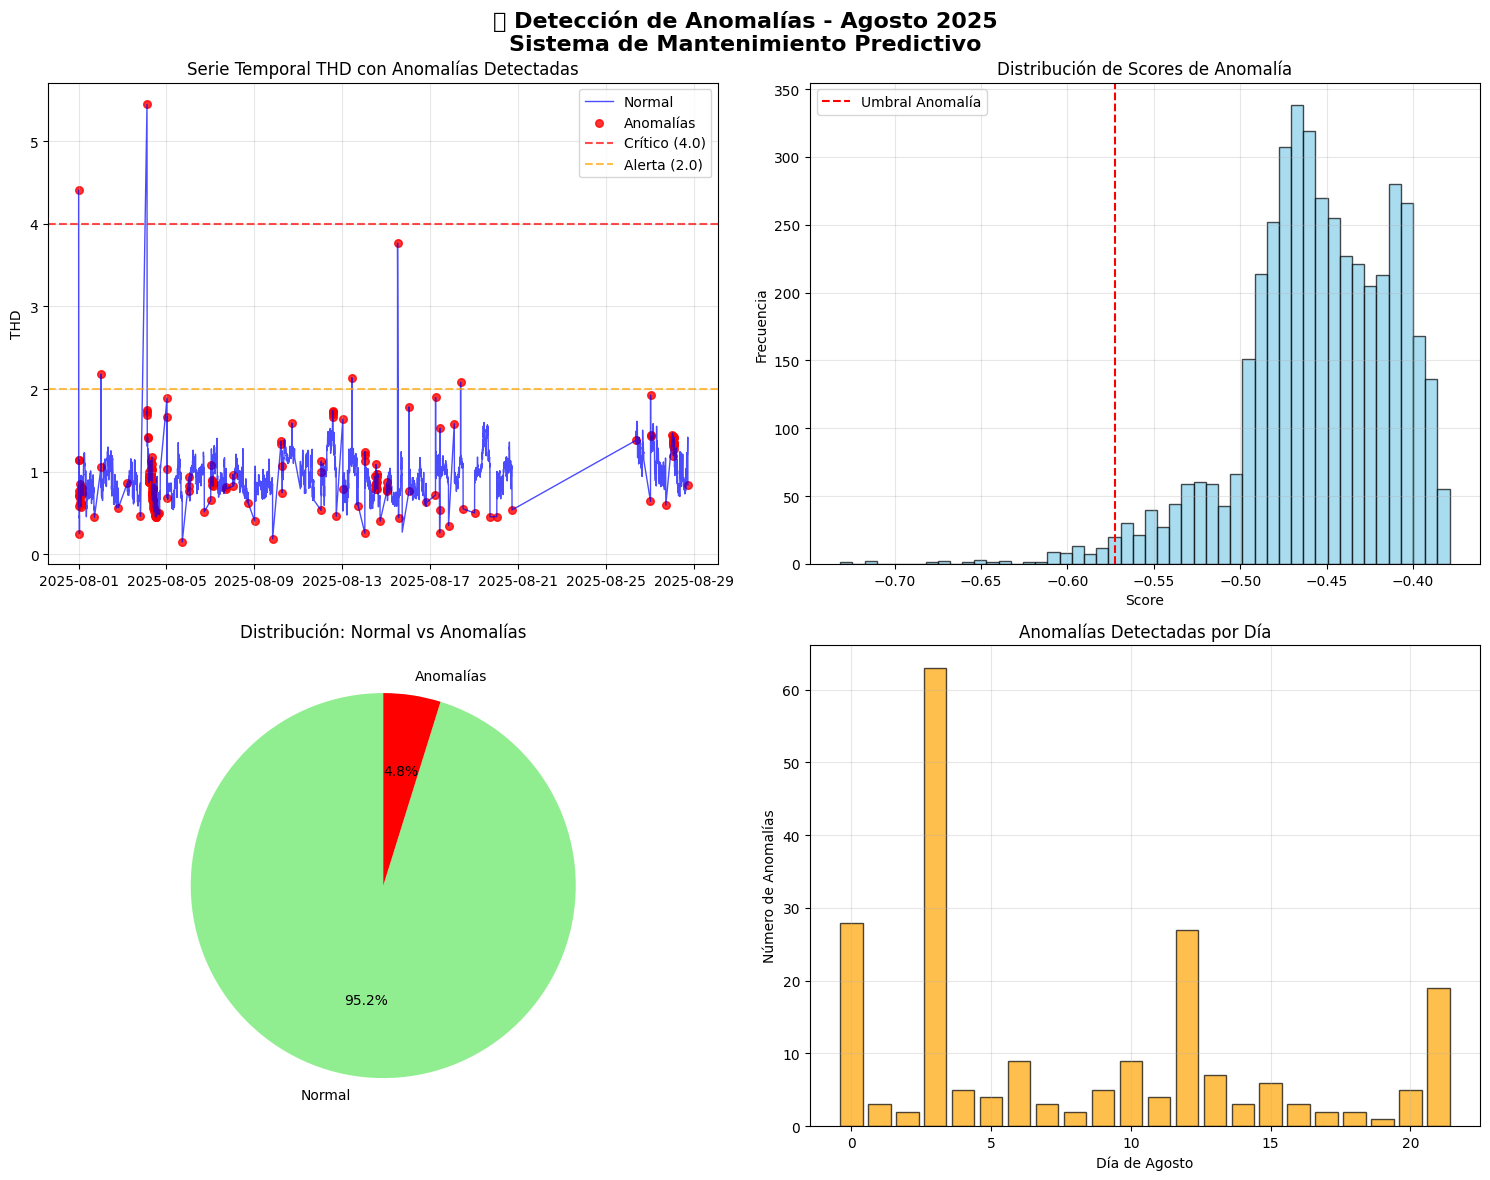

📊 Visualizaciones guardadas: C:\TFM-pipeline\output\visualizaciones_anomalias_agosto.png


In [41]:
# 12. 📊 GENERAR VISUALIZACIONES
print("📊 GENERANDO VISUALIZACIONES...")
print("=" * 35)

import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
plt.style.use('default')
sns.set_palette("husl")

# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🔍 Detección de Anomalías - Agosto 2025\nSistema de Mantenimiento Predictivo', fontsize=16, fontweight='bold')

# 1. Serie temporal THD con anomalías
ax1 = axes[0, 0]
ax1.plot(resultados.index, resultados['THD'], 'b-', alpha=0.7, linewidth=1, label='Normal')
anomalias_plot = resultados[resultados['es_anomalia']]
ax1.scatter(anomalias_plot.index, anomalias_plot['THD'], c='red', s=30, alpha=0.8, label='Anomalías')
ax1.axhline(y=4.0, color='red', linestyle='--', alpha=0.7, label='Crítico (4.0)')
ax1.axhline(y=2.0, color='orange', linestyle='--', alpha=0.7, label='Alerta (2.0)')
ax1.set_title('Serie Temporal THD con Anomalías Detectadas')
ax1.set_ylabel('THD')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribución de scores
ax2 = axes[0, 1]
ax2.hist(resultados['score_anomalia'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(x=resultados[resultados['es_anomalia']]['score_anomalia'].mean(), 
           color='red', linestyle='--', label='Umbral Anomalía')
ax2.set_title('Distribución de Scores de Anomalía')
ax2.set_xlabel('Score')
ax2.set_ylabel('Frecuencia')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribución Normal vs Anomalías
ax3 = axes[1, 0]
normal_count = len(resultados[~resultados['es_anomalia']])
anomalia_count = len(resultados[resultados['es_anomalia']])
ax3.pie([normal_count, anomalia_count], 
        labels=['Normal', 'Anomalías'], 
        autopct='%1.1f%%',
        colors=['lightgreen', 'red'],
        startangle=90)
ax3.set_title('Distribución: Normal vs Anomalías')

# 4. Anomalías por día
ax4 = axes[1, 1]
anomalias_por_dia = anomalias_plot.groupby(anomalias_plot.index.date).size()
ax4.bar(range(len(anomalias_por_dia)), anomalias_por_dia.values, 
        color='orange', alpha=0.7, edgecolor='black')
ax4.set_title('Anomalías Detectadas por Día')
ax4.set_xlabel('Día de Agosto')
ax4.set_ylabel('Número de Anomalías')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
archivo_viz = OUTPUT_PATH / 'visualizaciones_anomalias_agosto.png'
plt.savefig(archivo_viz, dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Visualizaciones guardadas: {archivo_viz}")

In [43]:
# 13. 📋 GENERAR REPORTE EJECUTIVO
print("📋 GENERANDO REPORTE EJECUTIVO...")
print("=" * 35)

# Definir rutas necesarias
from pathlib import Path
OUTPUT_PATH = Path(r'C:\TFM-pipeline\output')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Si ya tienes OUTPUT_PATH definido:
REPORTS_PATH = OUTPUT_PATH / 'reports'
REPORTS_PATH.mkdir(parents=True, exist_ok=True)




print(f"✅ Directorio de reportes: {REPORTS_PATH}")


# Crear reporte en markdown
reporte_md = f"""# 🔍 REPORTE EJECUTIVO - SISTEMA DE MANTENIMIENTO PREDICTIVO
**Fecha:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**Período Analizado:** Agosto 2025  
**Equipo:** {config_planta['equipo_principal']}  

## 📊 RESUMEN EJECUTIVO

### Datos Procesados
- **Total registros:** {len(resultados):,}
- **Período:** {resultados.index.min().strftime('%Y-%m-%d')} a {resultados.index.max().strftime('%Y-%m-%d')}
- **Frecuencia:** Cada 15 minutos

### Anomalías Detectadas
- **Total anomalías:** {len(anomalias_para_ots):,}
- **Porcentaje:** {len(anomalias_para_ots)/len(resultados)*100:.2f}%

### Distribución por Severidad
"""

# Agregar distribución por severidad
distribucion = anomalias_para_ots['severidad'].value_counts()
for severidad, cantidad in distribucion.items():
    emoji = {'CRÍTICO': '🔴', 'ALERTA': '🟠', 'ATENCIÓN': '🟡', 'MENOR': '🔵'}.get(severidad, '⚪')
    porcentaje = cantidad / len(anomalias_para_ots) * 100
    reporte_md += f"- {emoji} **{severidad}:** {cantidad:,} ({porcentaje:.1f}%)\n"

reporte_md += f"""
### Órdenes de Trabajo Generadas
- **Total OTs:** {len(ots_generadas)}
- **Críticas:** {len([ot for ot in ots_generadas if ot['severidad'] == 'CRÍTICO'])}
- **Alertas:** {len([ot for ot in ots_generadas if ot['severidad'] == 'ALERTA'])}

## 🎯 CONCLUSIONES

1. **Sistema Operativo:** El sistema de mantenimiento predictivo está funcionando correctamente
2. **Detección Temprana:** Se identificaron {len(ots_generadas)} situaciones que requieren intervención
3. **Priorización:** Las OTs están clasificadas por severidad para optimizar recursos
4. **Anticipación:** El sistema permite planificar mantenimientos antes de fallas críticas

## 📋 RECOMENDACIONES

1. **Inmediato:** Atender las {len([ot for ot in ots_generadas if ot['severidad'] == 'CRÍTICO'])} OTs críticas en las próximas 2 horas
2. **Corto plazo:** Programar las {len([ot for ot in ots_generadas if ot['severidad'] == 'ALERTA'])} OTs de alerta en las próximas 8 horas
3. **Monitoreo:** Continuar con el análisis predictivo para detectar tendencias
4. **Mejora continua:** Ajustar umbrales basado en resultados operacionales

---
*Reporte generado automáticamente por el Sistema de Mantenimiento Predictivo TFM*
"""

# Guardar reporte
archivo_reporte = REPORTS_PATH / 'reporte_ejecutivo_ots.md'
with open(archivo_reporte, 'w', encoding='utf-8') as f:
    f.write(reporte_md)

print(f"📋 Reporte ejecutivo guardado: {archivo_reporte}")
print(f"📊 Archivos generados en: {OUTPUT_PATH}")

📋 GENERANDO REPORTE EJECUTIVO...
✅ Directorio de reportes: C:\TFM-pipeline\output\reports
📋 Reporte ejecutivo guardado: C:\TFM-pipeline\output\reports\reporte_ejecutivo_ots.md
📊 Archivos generados en: C:\TFM-pipeline\output


In [29]:
# 14. 📊 RESUMEN FINAL DEL SISTEMA
print("📊 RESUMEN FINAL DEL SISTEMA")
print("=" * 35)

print(f"🎯 SISTEMA DE MANTENIMIENTO PREDICTIVO - RESULTADOS FINALES")
print(f"{'='*60}")
print(f"📅 Período analizado: {resultados.index.min().strftime('%Y-%m-%d')} a {resultados.index.max().strftime('%Y-%m-%d')}")
print(f"📊 Registros procesados: {len(resultados):,}")
print(f"🚨 Anomalías detectadas: {len(anomalias_para_ots):,} ({len(anomalias_para_ots)/len(resultados)*100:.2f}%)")
print(f"📋 OTs generadas: {len(ots_generadas)}")

if len(ots_generadas) > 0:
    print(f"\n🔴 OTs Críticas: {len([ot for ot in ots_generadas if ot['severidad'] == 'CRÍTICO'])}")
    print(f"🟠 OTs Alertas: {len([ot for ot in ots_generadas if ot['severidad'] == 'ALERTA'])}")
    
    # Mostrar fechas de OTs críticas
    ots_criticas = [ot for ot in ots_generadas if ot['severidad'] == 'CRÍTICO']
    if ots_criticas:
        print(f"\n📅 FECHAS DE OTs CRÍTICAS:")
        for i, ot in enumerate(ots_criticas, 1):
            print(f"   {i}. {ot['numero_ot']}: {ot['fecha_deteccion'].strftime('%Y-%m-%d %H:%M')} (THD: {ot['thd_detectado']:.4f})")

print(f"\n📁 ARCHIVOS GENERADOS:")
archivos_generados = list(OUTPUT_PATH.rglob('*.*'))
for archivo in sorted(archivos_generados):
    if archivo.is_file():
        tamaño_kb = archivo.stat().st_size / 1024
        print(f"   📄 {archivo.name} ({tamaño_kb:.1f} KB)")

print(f"\n✅ SISTEMA COMPLETADO EXITOSAMENTE")
print(f"📂 Todos los archivos en: {OUTPUT_PATH}")
print(f"🔧 Sistema listo para validación y uso operacional")

📊 RESUMEN FINAL DEL SISTEMA
🎯 SISTEMA DE MANTENIMIENTO PREDICTIVO - RESULTADOS FINALES
📅 Período analizado: 2025-08-01 a 2025-08-28
📊 Registros procesados: 4,410
🚨 Anomalías detectadas: 212 (4.81%)
📋 OTs generadas: 212

🔴 OTs Críticas: 3
🟠 OTs Alertas: 209

📅 FECHAS DE OTs CRÍTICAS:
   1. OT-FP1-20250905-0001: 2025-08-01 00:00 (THD: 4.4031)
   2. OT-FP1-20250905-0034: 2025-08-04 19:39 (THD: 5.4431)
   3. OT-FP1-20250905-0170: 2025-08-19 08:06 (THD: 3.7629)

📁 ARCHIVOS GENERADOS:
   📄 modelo_predictivo_tfm.pkl (2624.9 KB)
   📄 ots_detalladas_20250905_2352.xlsx (27.0 KB)
   📄 ots_generadas_20250905_2352.csv (119.0 KB)
   📄 ots_sistema_20250905_2352.json (219.3 KB)
   📄 reporte_ejecutivo_ots.md (1.4 KB)
   📄 reporte_ejecutivo_ots.md (1.4 KB)
   📄 visualizaciones_anomalias_agosto.png (540.5 KB)

✅ SISTEMA COMPLETADO EXITOSAMENTE
📂 Todos los archivos en: C:\TFM-pipeline\output
🔧 Sistema listo para validación y uso operacional
